# Network Data Analysis of Passenger Flight Data

In [26]:
# Import necessary libraries

#!pip install contextily
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.graph_objects as go
import networkx as nx
import warnings
import airportsdata
import math 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from collections import Counter
from operator import itemgetter
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np

%matplotlib inline

from IPython.display import display
from ipywidgets import widgets, interactive

import contextily as cx
#from mpl_toolkits.basemap import Basemap

warnings.filterwarnings('ignore')

## Data Preparation

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')


In [28]:
airports = pd.read_csv('Airports.csv',encoding= 'unicode_escape').iloc[:,[0,3,4]].rename(columns= {'Lat ':'Lat'})
airports_2= pd.read_csv('iata-icao.csv',encoding= 'unicode_escape').iloc[:,[2,5,6]].rename(columns={'iata':'id','longitude':'Lon','latitude':'Lat'})
flights = pd.read_excel(r'Flight Data.xlsx')

In [29]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9033 entries, 0 to 9032
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      9033 non-null   object 
 1   Lat     9033 non-null   float64
 2   Lon     9033 non-null   float64
dtypes: float64(2), object(1)
memory usage: 211.8+ KB


In [30]:
airports.head()


,id,Lat,Lon
0,BIN,34.800000,67.816667
1,BST,31.582998,64.360000
2,CCN,34.516701,65.250001
3,DAZ,38.466667,70.883333
4,FAH,32.391730,62.096819


In [31]:
airports[airports.duplicated()]  # There is no duplicates
airports.isna().sum() # No NAs

id     0
Lat    0
Lon    0
dtype: int64

In [32]:
airports_2.head()

,id,Lat,Lon
0,SHJ,25.328600,55.51720047
1,AZI,24.428301,54.45809937
2,FJR,25.112200,56.32400131
3,XSB,24.283611,52.580278
4,RKT,25.613501,55.93880081


In [33]:
# Merge both of the airport data
all_airports= airports.merge(airports_2,how='outer',on='id')

In [34]:
for i in range(0,len(all_airports)):
        if math.isnan(all_airports.Lat_x[i]):
            all_airports.Lat_x[i]=all_airports.Lat_y[i]
            all_airports.Lon_x[i]=all_airports.Lon_y[i]
        elif math.isnan(all_airports.Lat_y[i]):
            all_airports.Lat_y[i]=all_airports.Lat_x[i]
            all_airports.Lon_y[i]=all_airports.Lon_x[i]
        elif (math.isnan(all_airports.Lat_y[i])==False) & (all_airports.Lat_x[i]!=all_airports.Lat_y[i]) :
            all_airports.Lat_y[i]=all_airports.Lat_x[i]
            all_airports.Lon_y[i]=all_airports.Lon_x[i]
        else:
            pass

In [35]:
all_airports=all_airports.drop(columns=['Lat_y','Lon_y'],axis=1).rename(columns={'Lat_x':'Lat','Lon_x':'Lon'})

In [36]:
all_airports # Now we're ready with all of the Airport info

,id,Lat,Lon
0,BIN,34.800000,67.816667
1,BST,31.582998,64.36
2,CCN,34.516701,65.250001
3,DAZ,38.466667,70.883333
4,FAH,32.391730,62.096819
...,...,...,...
9855,GIY,-23.283300,30.64999962
9856,NCS,-27.770599,29.9769001
9857,PCF,-26.671000,27.08189964
9858,JEK,-15.633400,29.6036


In [37]:
all_airports.isna().sum() # No NAs

id     0
Lat    0
Lon    0
dtype: int64

In [38]:
# Data Exploration and Cleaning

# Displaying the first few rows of the flights dataset
flights.head()

# Data Cleaning: Modifying country names for convenience

# Change "USA" to "United States of America" for consistency and convenience
flights.replace('USA', 'United States of America', inplace=True)

# Correcting wrong country values
# Some countries are incorrectly labeled as "Hong Kong (sar) China" and "Macao (sar) China"
# We will replace these values with "China"
flights.replace(to_replace=["Hong Kong (sar) China", "Macao (sar) China"], value="China", inplace=True)

# Including United States Minor Outlying Islands and Virgin Islands, US in the United States of America category
flights.replace(to_replace=["United States Minor Outlying Islands", "Virgin Islands, US"],
                value="United States of America", inplace=True)

# Printing information about the flights dataset after cleaning
flights.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60470 entries, 0 to 60469
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source          60470 non-null  object
 1   Source City     60470 non-null  object
 2   Source Country  60470 non-null  object
 3   Target          60470 non-null  object
 4   Target City     60470 non-null  object
 5   Target Country  60470 non-null  object
 6   Weight          60470 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 3.2+ MB


In [39]:
# Removing Duplicate Rows

# Finding duplicate rows in the flights dataset
duplicates = flights[flights.duplicated()]

# Counting the number of duplicates
num_duplicates = len(duplicates)

# Displaying the number of duplicates found
print(f"Number of duplicates in the flights dataset: {num_duplicates}")

# Removing the duplicate rows from the flights dataset
flights.drop_duplicates(inplace=True)
flights=flights.reset_index(drop=True)
# Confirming that duplicates have been removed
print("Duplicate rows removed from the flights dataset.")


Number of duplicates in the flights dataset: 216
Duplicate rows removed from the flights dataset.


In [40]:

missing_values = flights.isna().sum()

# Displaying the count of missing values
print("Number of missing values in the flights dataset:")
print(missing_values)

flights.info()

# Updated Dataset Information

# The updated flights dataset now contains 60,254 rows.
# There are no missing values present in any column of the dataset.


Number of missing values in the flights dataset:
Source            0
Source City       0
Source Country    0
Target            0
Target City       0
Target Country    0
Weight            0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60254 entries, 0 to 60253
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Source          60254 non-null  object
 1   Source City     60254 non-null  object
 2   Source Country  60254 non-null  object
 3   Target          60254 non-null  object
 4   Target City     60254 non-null  object
 5   Target Country  60254 non-null  object
 6   Weight          60254 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 3.2+ MB


### What are the top 10 countries having the most frequent flights?

        Target Country       Flights
0  United States of America   14818 
1                   Germany    3295 
2                     China    3209 
3                     Spain    2209 
4                    Canada    2109 
5        Russian Federation    1944 
6            United Kingdom    1929 
7                    France    1666 
8                     Japan    1477 
9                     Italy    1382 


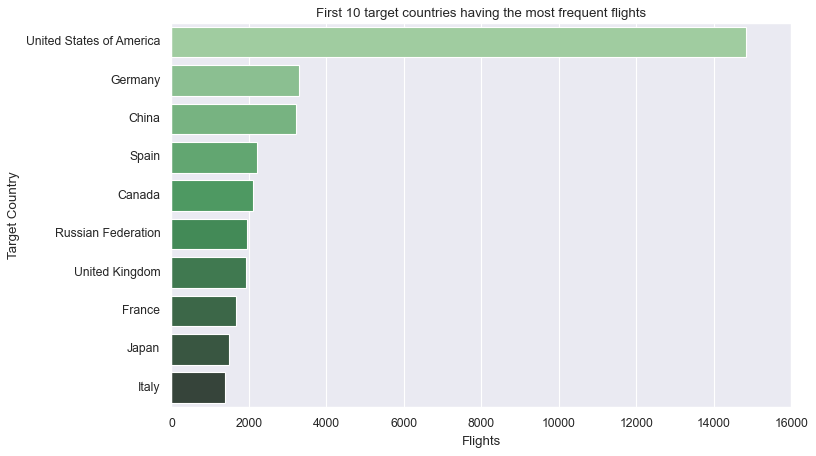

In [43]:
# Counting the number of flights to each target country and selecting the top 10 countries
target_country_df_10 = flights['Target Country'].value_counts().sort_values(ascending=False).head(10).to_frame().reset_index()

# Renaming the columns of the DataFrame
target_country_df_10.columns = ['Target Country', 'Flights']

# Displaying the DataFrame with the top 10 target countries and their corresponding flight counts
print(target_country_df_10)

# Creating a bar plot to visualize the top 10 target countries with the most frequent flights
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(y="Target Country", x='Flights', data=target_country_df_10, palette="Greens_d").set(title='First 10 target countries having the most frequent flights')
plt.show()

### Data Filtering to work with only USA, China, UK and Australia

        Target Country       Flights
0  United States of America   13251 
1                     China    2738 
2                 Australia    1043 
3            United Kingdom     635 


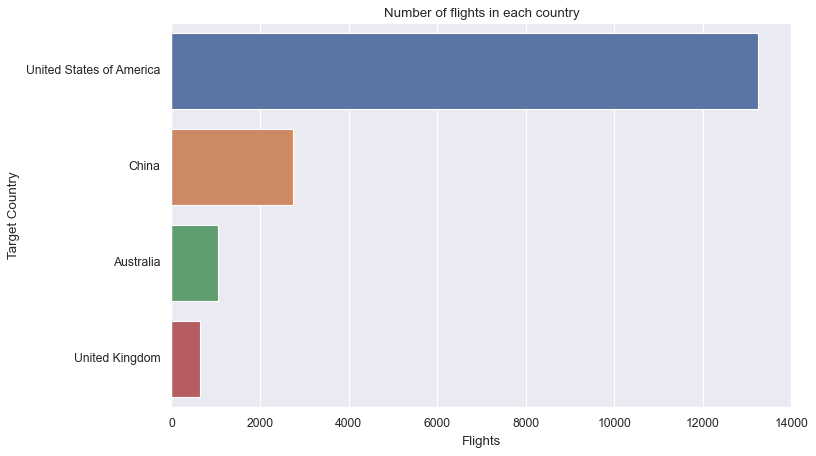

In [45]:
# Data Filtering for Domestic Flights in USA, China, UK, and Australia

# Filtering the flights dataset for domestic flights originating from the United States of America, China, United Kingdom, and Australia
flights_f = flights[((flights['Source Country'] == "United States of America") | (flights['Source Country'] == "China")
                     | (flights['Source Country'] == "United Kingdom") | (flights['Source Country'] == "Australia"))
                    & (flights['Target Country'] == flights['Source Country'])]

# Counting the number of flights to each target country in the filtered dataset
target_country_flights_f = flights_f['Target Country'].value_counts().sort_values(ascending=False).to_frame().reset_index()

# Renaming the columns of the DataFrame
target_country_flights_f.columns = ['Target Country', 'Flights']

# Displaying the DataFrame with the number of flights in each country
print(target_country_flights_f)

# Creating a bar plot to visualize the number of flights in each country
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.barplot(y="Target Country", x='Flights', data=target_country_flights_f).set(title='Number of flights in each country')
plt.show()


In [46]:
# Merging Flights and Airports Dataframes

# Merging the flights_f dataframe with the all_airports dataframe to get the source airport's latitude and longitude
flights_f_source_merged = flights_f.merge(all_airports, how="left", left_on='Source', right_on='id')

# Merging the flights_f_source_merged dataframe with the all_airports dataframe again to get the target airport's latitude and longitude
flights_merged = flights_f_source_merged.merge(all_airports, how="left", left_on='Target', right_on='id')\
                                        .drop(columns=['id_x', 'id_y'])\
                                        .rename(columns={'Lat_x': 'Lat Source', 'Lon_x': 'Lon Source',
                                                         'Lat_y': 'Lat Target', 'Lon_y': 'Lon Target'})

# Converting latitude and longitude columns to float data type
flights_merged['Lon Source'] = flights_merged['Lon Source'].astype(float)
flights_merged['Lon Target'] = flights_merged['Lon Target'].astype(float)

# Manually inserting latitude and longitude values for the airports with missing coordinates
flights_merged.iat[81, 7] = 22.1971  # Source: XZM
flights_merged.iat[81, 8] = 113.559

flights_merged.iat[8851, 7] = 35.967  # Source: JGC
flights_merged.iat[8851, 8] = -112.133

flights_merged.iat[9681, 7] = 58.683333  # Source: PNF
flights_merged.iat[9681, 8] = -156.833333

flights_merged.iat[80, 9] = 22.1971  # Target: XZM
flights_merged.iat[80, 10] = 113.559

flights_merged.iat[8797, 9] = -10.586389
flights_merged.iat[8797, 10] = 142.29  # Target: TIS

flights_merged.iat[8850, 9] = 55.967  # Target: JGC
flights_merged.iat[8850, 10] = -112.133

flights_merged.iat[9677, 9] = 58.683333  # Target: PNF
flights_merged.iat[9677, 10] = -156.833333

# Checking for missing values in the merged dataframe after manually inserting coordinates
print("Missing values in the merged dataframe after inserting coordinates:")
print(flights_merged.isna().sum())


Missing values in the merged dataframe after inserting coordinates:
Source            0
Source City       0
Source Country    0
Target            0
Target City       0
Target Country    0
Weight            0
Lat Source        0
Lon Source        0
Lat Target        0
Lon Target        0
dtype: int64


# Separate Airline Network for Each Country (Internal flights only)

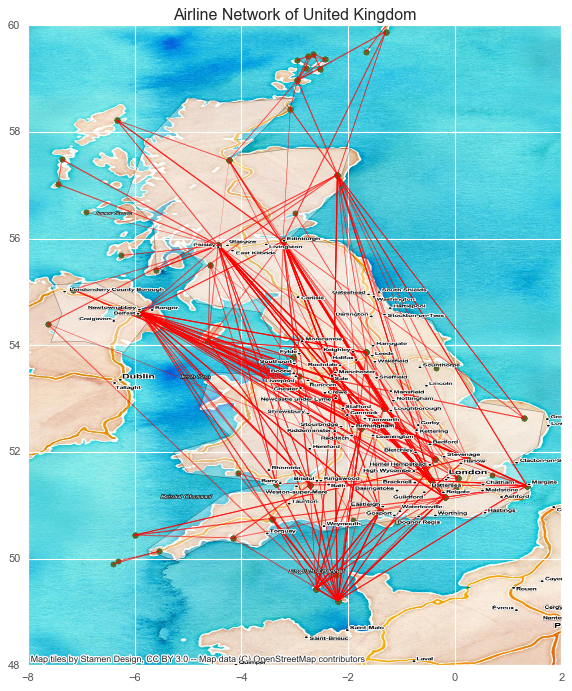

In [49]:
def networkplot(country):
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    country_df = flights_merged[flights_merged['Target Country'] == country]

    with plt.style.context(("seaborn", "ggplot")):
        # Plot world map
        ax = world[world.name == country].plot(figsize=(20, 10), edgecolor="black", color="white", alpha=0.4)
        
        # Add basemaps for watercolor and toner labels using contextily
        cx.add_basemap(ax, crs=world[world.name == country].crs.to_string(), source=cx.providers.Stamen.Watercolor)
        cx.add_basemap(ax, crs=world[world.name == country].crs.to_string(), source=cx.providers.Stamen.TonerLabels)
        
        # Plot network connections
        for slat, tlat, slon, tlon, weight in zip(country_df["Lat Source"], country_df["Lat Target"],
                                                   country_df["Lon Source"], country_df["Lon Target"],
                                                   preprocessing.normalize(country_df["Weight"].reset_index()).reshape(-1, 1)):
            plt.plot([slon, tlon], [slat, tlat], linewidth=weight, color="red", alpha=0.5)
            plt.scatter([slon, tlon], [slat, tlat], color="darkolivegreen", alpha=1)

        plt.title("Airline Network of {}".format(country))
        plt.savefig('{}_network.png'.format(country.replace(" ", "_")), format='png', transparent=True)
        plt.show()

"""

# Loop through all unique target countries and generate network plots (may take a while)
for country in flights_merged['Target Country'].unique():
    networkplot(country)
"""
networkplot('United Kingdom')

In [50]:
# Alternative show-case with user drop-down menu:
v = interactive(networkplot, country=(['United Kingdom', 'China','United States of America','Australia']))
display(v)

interactive(children=(Dropdown(description='country', options=('United Kingdom', 'China', 'United States of Am…

#  Degree, Betweenness and Assortativity Plots 

### a) Degree distribution (x-axis: descending rank, y-axis: logscale of weighted degree)
### b) Degree vs. betweenness distribution
### c) Assortativity (degree-degree correlation) and state the value of Assortativity 


In [52]:
# Network object for all countries:
G = nx.from_pandas_edgelist(flights_merged,                           
                                 source = 'Source', target = 'Target', 
                                edge_attr = 'Weight',create_using = nx.DiGraph())

def degree_betweennes_assortativity (method):
    for i in flights_merged['Target Country'].unique():     
        country_df= flights_merged[flights_merged['Target Country']==i]
        G_country = nx.from_pandas_edgelist(country_df,                           
                                 source = 'Source', target = 'Target', 
                                edge_attr = 'Weight',create_using = nx.DiGraph())
        degrees_df = pd.DataFrame(sorted(G_country.degree(weight='Weight'))).rename(columns={0: 'id', 1:'degrees'})
        
        betweenness_centrality_df=pd.DataFrame(nx.betweenness_centrality(G_country,weight='Weight').items(), 
                                               columns=['id', 'betweennes'])
        
        assort_pdf=pd.DataFrame(nx.average_neighbor_degree(G_country,source='out',
                                                           target='in',weight='Weight').items(),columns=['id','average_neighbor_degree'])
        assort_pearson= nx.degree_pearson_correlation_coefficient(G_country,x='out',
                                                           y='in',weight='Weight')
        
        if (method=='Degree Distribution'):
            plt.style.use('ggplot')              
            degrees = pd.DataFrame(sorted([val for (node, val) in sorted(G_country.degree(weight='Weight'))],reverse=True))
            plt.plot(degrees)
            plt.grid(color='w', linestyle='solid')
            plt.yscale('log')
            plt.xlabel('Rank') 
            plt.ylabel('Log-scale of Weighted Degree')
            plt.title("Degree Distribution of {country}".format(country=i))
            plt.show() 
        elif (method=='Degree vs Betweenness Distribution'):
            betweenness_centrality_plot=betweenness_centrality_df.merge(degrees_df,how='inner',on='id')
            plt.style.use('ggplot')
            plt.grid(color='w', linestyle='solid')
            plt.scatter(betweenness_centrality_plot.degrees,betweenness_centrality_plot.betweennes)
            plt.xscale('log')
            plt.yscale('log')
            plt.xlabel('Log-scale of Weighted Degree') 
            plt.ylabel('Log-scale of Betweenness')
            plt.title("Degree vs Betweenness Distribution of {country}".format(country=i))
            plt.show()         
            print("Pearson Correlation Coefficient of Betweennness and Degree for {country}: ".format(country=i),np.corrcoef(betweenness_centrality_plot.degrees,betweenness_centrality_plot.betweennes)[0,1])
        elif (method=='Assortativity'):
            degree_assort_plot=degrees_df.merge(assort_pdf,how='inner',on='id')
            plt.grid(color='w', linestyle='solid')
            plt.scatter(degree_assort_plot.degrees,degree_assort_plot.average_neighbor_degree)
            plt.xscale('log')
            plt.xlabel('Log-scale of Weighted Degree') 
            plt.ylabel('Average Neighbor Degree (Assortativity)')
            plt.title("Assortativity (degree-degree correlation) Plot of {country}".format(country=i))
            plt.show() 
            print("Degree Pearson Assortativity Correlation Coefficient of {country}: ".format(country=i),assort_pearson)


        else:
            pass
        


In [ ]:
degree_betweennes_assortativity('Degree Distribution')


Here, a degree means the number of relations (edges) a node has. By using weighted degrees, weights of the edges (number of people who used that specific flight) are considered by summing weights assigned to the node’s direct connections.

- China has an almost negative linear distribution meaning that higher ranks have a lower log-scale weighted degree while lower ranks have a higher log-scale weighted degree. Similarly, the UK also shows a negative association between rank and log- scale of weighted degree; but it has some fluctuations, and it is not as linear as China’s plot.
- USA and Australia have very similar distributions regarding their behaviour, whilst the distribution of the USA has a clearer shape due to its dataset’s size. They also demonstrate a negative relationship between log-scale weighted degree and rank.


In [ ]:
degree_betweennes_assortativity('Degree vs Betweenness Distribution')

Another centrality measurement is betweenness. Betweenness degree is a measurement to find the extent to which a certain vertex lies on the shortest paths between other vertices. That is, it is useful to find the node playing the role of a “bridge” in a [network](https://www.sciencedirect.com/science/article/pii/B9780123822291000163). Here, the relationship between the weighted degree centrality and betweenness centrality is examined within a scatter plot.
Valente et al. (2008) indicate that the correlation between degree and betweenness measurement demonstrates that both are distinct yet conceptually associated measures. Parallel to this, a high correlation in these measures indicates the hub–spoke (HS) model, meaning that these highly connected degrees also behave as the shortest path in other route (Guo et al., 2019).

In this case, we first examine the plots of this relationship, and then calculate the correlations.

- There is an obvious positive linear relationship in China’s plot, indicating the HS model (Guo et al., 2019)
- Similarly, there is a strong positive linear relationship in Australia’s and USA’s plots, but the relationship seems to start in later nodes, indicating the HS model 
- On the contrary, there seems to be no obvious linear pattern in the plot of the UK.
However, these comments are only high-level interpretations. It is better to check the real correlation coefficient in these values for each country.

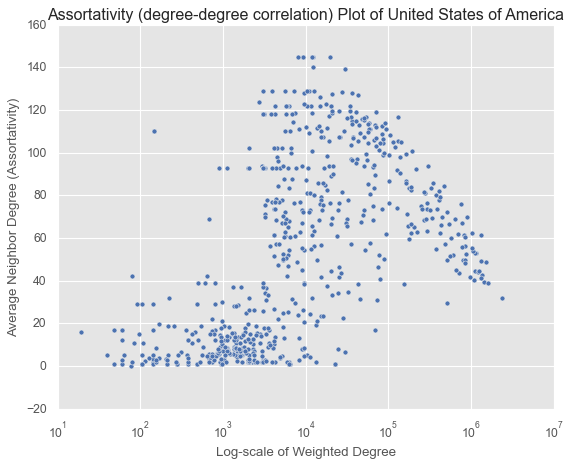

Degree Pearson Assortativity Correlation Coefficient of United States of America:  -0.15118708885044138


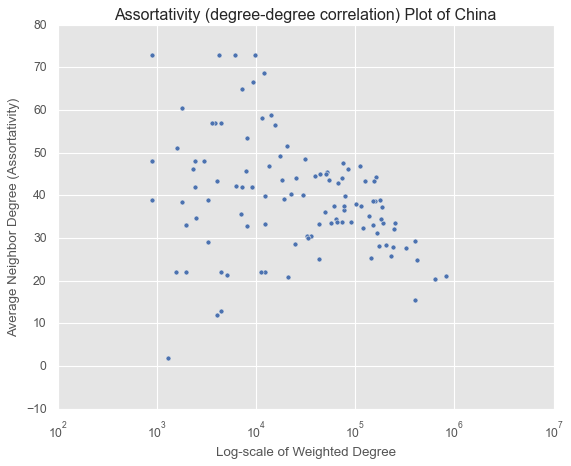

Degree Pearson Assortativity Correlation Coefficient of China:  -0.3274137406113734


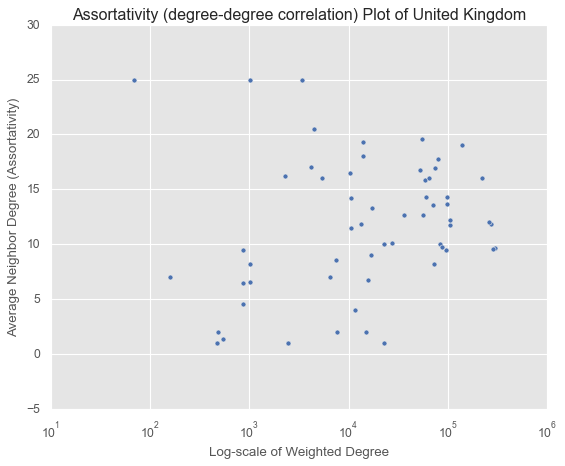

Degree Pearson Assortativity Correlation Coefficient of United Kingdom:  0.02154504160885324


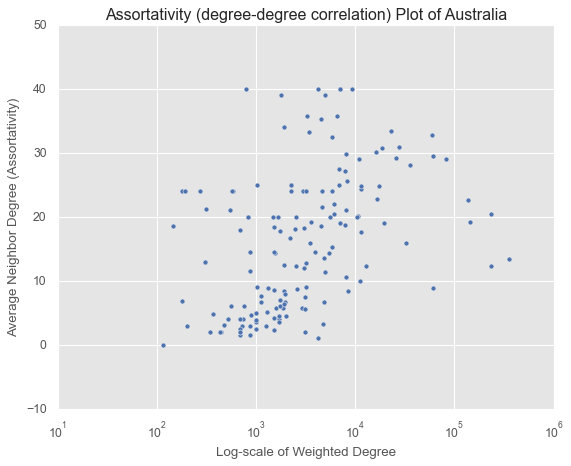

Degree Pearson Assortativity Correlation Coefficient of Australia:  -0.12195118323658227


In [56]:
degree_betweennes_assortativity('Assortativity')

Two methods are used to analyze the degree-degree correlation in the flight networks of different countries.

- The first method calculates the average degree of a node's neighbors to determine the degree-degree correlation. The results are plotted, showing the average degree of each node's neighborhood against the logarithm of its weighted degree.

- Based on the plots, China exhibits a strong negative degree-degree correlation compared to other countries. The USA and Australia also show a negative correlation, although not as strong as China. The United Kingdom, on the other hand, does not display a clear linear relationship in its degree-degree correlation.

- The second method calculates the Degree Pearson Assortativity Correlation Coefficient (represented by "r") for each country individually. This coefficient measures the assortativity of the network based on node degree.

- For Australia, the USA, and China, the coefficients are negative (-0.12, -0.15, -0.32, respectively), indicating a disassortative network where nodes with high degrees connect to nodes with low degrees, and vice versa. China has the most disassortative network among these countries, with the lowest coefficient value of -0.32.

- For the United Kingdom, the coefficient is slightly positive (0.021), suggesting an assortative flight network. However, the coefficient is close to 0, indicating a weak assortativity. This means that the connections in the UK network show some similarity in terms of node degrees but to a lesser extent compared to other countries.

- Overall, the Assortativity Correlation Coefficient for all countries combined is 0.0068.

In [54]:
# Alternative:

# Display with user drop-down menu:
v = interactive(degree_betweennes_assortativity, method=(['Degree vs Betweenness Distribution', 'Degree Distribution','Assortativity']))
display(v)

interactive(children=(Dropdown(description='method', options=('Degree vs Betweenness Distribution', 'Degree Di…

In [57]:
print("Degree Pearson Assortativity Correlation Coefficient of all countries: ",nx.degree_pearson_correlation_coefficient(G,x='out',
                                                           y='in',weight='Weight'))


Degree Pearson Assortativity Correlation Coefficient of all countries:  0.005666644536928449


## The Core Periphery Structure

### USA

Text(30    30
dtype: int64, 154, 'K+ = 144')

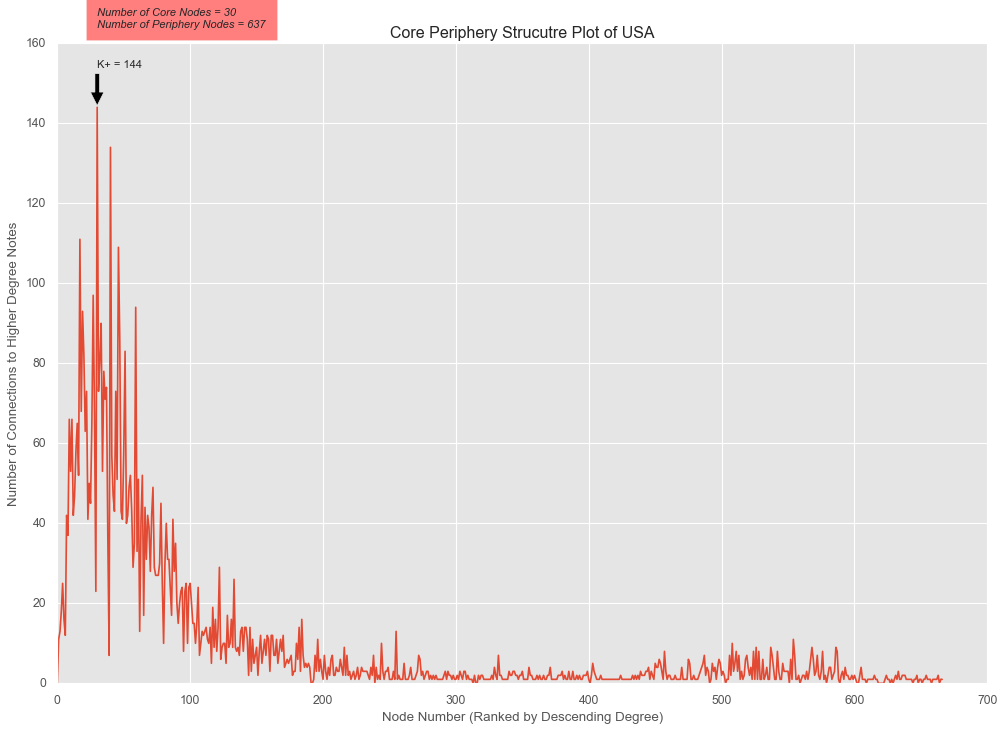

In [65]:

usa=flights_merged[flights_merged['Source Country']=='United States of America'].reset_index(drop=True)

G_usa = nx.from_pandas_edgelist(usa,                           
                                source = 'Source', 
                                target = 'Target', 
                                edge_attr = 'Weight',
                                create_using = nx.DiGraph())
degrees= G_usa.degree(weight='Weight')
usa_community_size = usa[['Source','Target']]
usa_community_size['Source Degree']=''
usa_community_size['Target Degree']=''
usa_community_size['Coreness']=''

for i in range(0,len(usa_community_size)):
    usa_community_size.loc[i,'Source Degree'] = degrees[usa_community_size.Source[i]]
    usa_community_size.loc[i,'Target Degree'] = degrees[usa_community_size.Target[i]]
    
    if degrees[usa_community_size.Target[i]] > degrees[usa_community_size.Source[i]]:
        usa_community_size.Coreness[i] = 1
    else:
        usa_community_size.Coreness[i] = 0
        
usa_community_size=usa_community_size.groupby('Source',as_index=False).agg({'Source':'first','Source Degree':'first','Coreness':'sum'}).reset_index(drop=True)
usa_community_size=usa_community_size.sort_values(by='Source Degree',ascending=False)

coreness = usa_community_size.Coreness.reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel('Node Number (Ranked by Descending Degree)')
ax1.set_ylabel('Number of Connections to Higher Degree Notes')
ax1.plot(coreness.tolist())
ax1.set_title("Core Periphery Strucutre Plot of USA")

max_coreness_pos = sum(np.where(coreness == max(coreness)))
max_coreness = max(coreness)
x = pd.Series(range(0,len(coreness)))
xmax =  x[max_coreness_pos]


ax1.text(xmax, max_coreness+20, 'Number of Core Nodes = {max_coreness_pos}\nNumber of Periphery Nodes = {perip}'.format(max_coreness_pos=sum(max_coreness_pos),perip=(len(coreness)-sum(max_coreness_pos))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.annotate('K+ = {max_coreness}'.format(max_coreness=max_coreness), xy=(xmax, max_coreness), xytext=(xmax, max_coreness+10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )




### China

Text(15    15
dtype: int64, 64, 'K+ = 54')

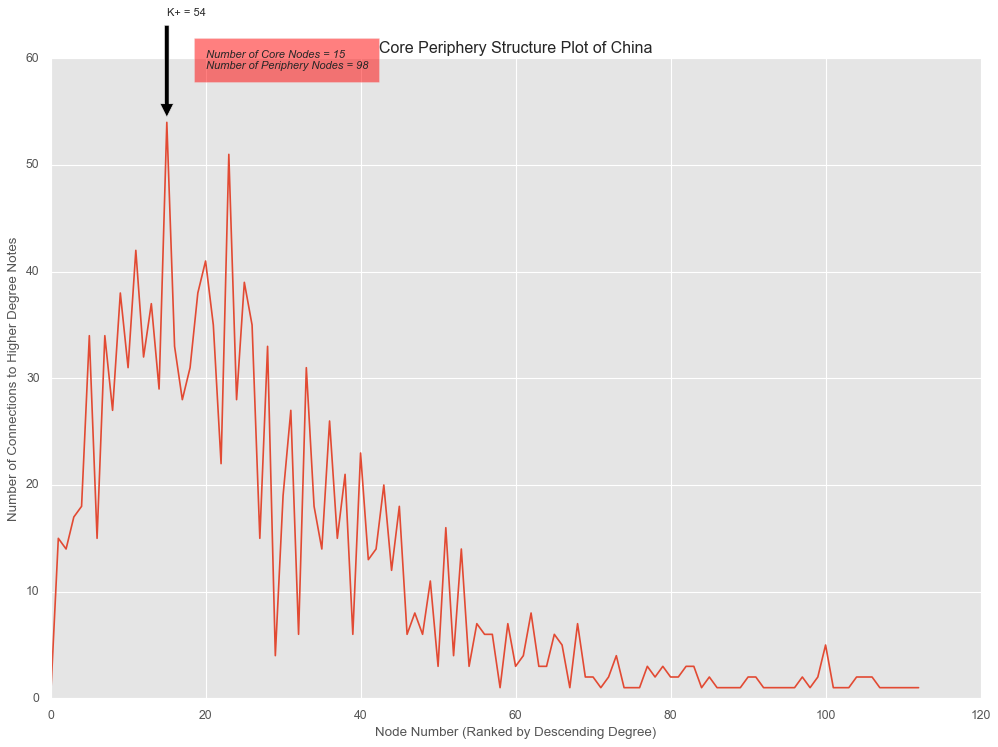

In [64]:

china=flights_merged[flights_merged['Source Country']=='China'].reset_index(drop=True)

G_china = nx.from_pandas_edgelist(china,                           
                                source = 'Source', 
                                target = 'Target', 
                                edge_attr = 'Weight',
                                create_using = nx.DiGraph())
degrees= G_china.degree(weight='Weight')
china_community_size = china[['Source','Target']]
china_community_size['Source Degree']=''
china_community_size['Target Degree']=''
china_community_size['Coreness']=''

for i in range(0,len(china_community_size)):
    china_community_size.loc[i,'Source Degree'] = degrees[china_community_size.Source[i]]
    china_community_size.loc[i,'Target Degree'] = degrees[china_community_size.Target[i]]
    
    if degrees[china_community_size.Target[i]] > degrees[china_community_size.Source[i]]:
        china_community_size.Coreness[i] = 1
    else:
        china_community_size.Coreness[i] = 0
china_community_size=china_community_size.groupby('Source',as_index=False).agg({'Source':'first','Source Degree':'first','Coreness':'sum'}).reset_index(drop=True)
china_community_size=china_community_size.sort_values(by='Source Degree',ascending=False)

coreness = china_community_size.Coreness.reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(coreness.tolist())
ax1.set_xlabel('Node Number (Ranked by Descending Degree)')
ax1.set_ylabel('Number of Connections to Higher Degree Notes')
ax1.set_title('Core Periphery Structure Plot of China')

max_coreness_pos = sum(np.where(coreness == max(coreness)))
max_coreness = max(coreness)
x = pd.Series(range(0,len(coreness)))
xmax =  x[max_coreness_pos]


ax1.text(xmax+5, max_coreness+5, 'Number of Core Nodes = {max_coreness_pos} \nNumber of Periphery Nodes = {perip}'.format(max_coreness_pos=sum(max_coreness_pos),perip=(len(coreness)-sum(max_coreness_pos))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.annotate('K+ = {max_coreness}'.format(max_coreness=max_coreness), xy=(xmax, max_coreness), xytext=(xmax, max_coreness+10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
 





### United Kingdom

Text(9    9
dtype: int64, 41, 'K+ = 31')

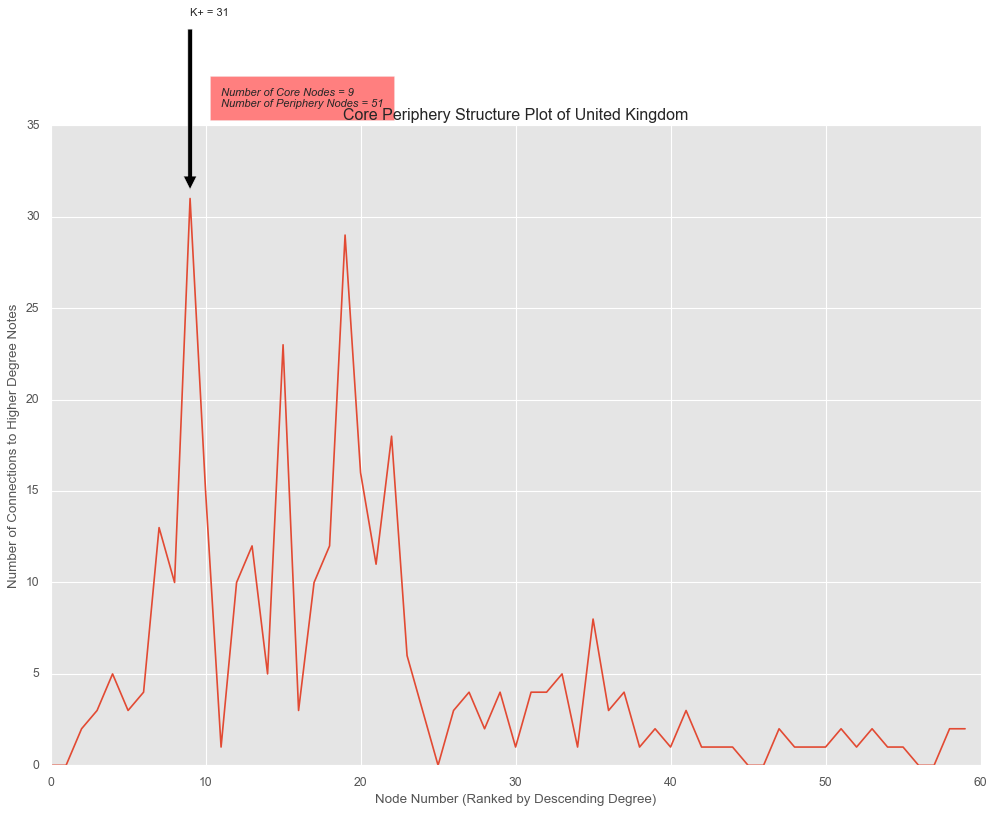

In [63]:

uk=flights_merged[flights_merged['Source Country']=='United Kingdom'].reset_index(drop=True)

G_uk = nx.from_pandas_edgelist(uk,                           
                                source = 'Source', 
                                target = 'Target', 
                                edge_attr = 'Weight',
                                create_using = nx.DiGraph())
degrees= G_uk.degree(weight='Weight')
uk_community_size = uk[['Source','Target']]
uk_community_size['Source Degree']=''
uk_community_size['Target Degree']=''
uk_community_size['Coreness']=''

for i in range(0,len(uk_community_size)):
    uk_community_size.loc[i,'Source Degree'] = degrees[uk_community_size.Source[i]]
    uk_community_size.loc[i,'Target Degree'] = degrees[uk_community_size.Target[i]]
    
    if degrees[uk_community_size.Target[i]] > degrees[uk_community_size.Source[i]]:
        uk_community_size.Coreness[i] = 1
    else:
        uk_community_size.Coreness[i] = 0
uk_community_size=uk_community_size.groupby('Source',as_index=False).agg({'Source':'first','Source Degree':'first','Coreness':'sum'}).reset_index(drop=True)
uk_community_size=uk_community_size.sort_values(by='Source Degree')
uk_community_size=uk_community_size.sort_values(by='Source Degree',ascending=False)


coreness = uk_community_size.Coreness.reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.set_xlabel('Node Number (Ranked by Descending Degree)')
ax1.set_ylabel('Number of Connections to Higher Degree Notes')
ax1.plot(coreness.tolist())
ax1.set_title('Core Periphery Structure Plot of United Kingdom')

max_coreness_pos = sum(np.where(coreness == max(coreness)))
max_coreness = max(coreness)
x = pd.Series(range(0,len(coreness)))
xmax =  x[max_coreness_pos]

ax1.text(xmax+2, max_coreness+5, 'Number of Core Nodes = {max_coreness_pos}\nNumber of Periphery Nodes = {perip}'.format(max_coreness_pos=sum(max_coreness_pos),perip=(len(coreness)-sum(max_coreness_pos))), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.annotate('K+ = {max_coreness}'.format(max_coreness=max_coreness), xy=(xmax, max_coreness), xytext=(xmax, max_coreness+10),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )





### Australia


Text(10, 29, 'K+ = 22')

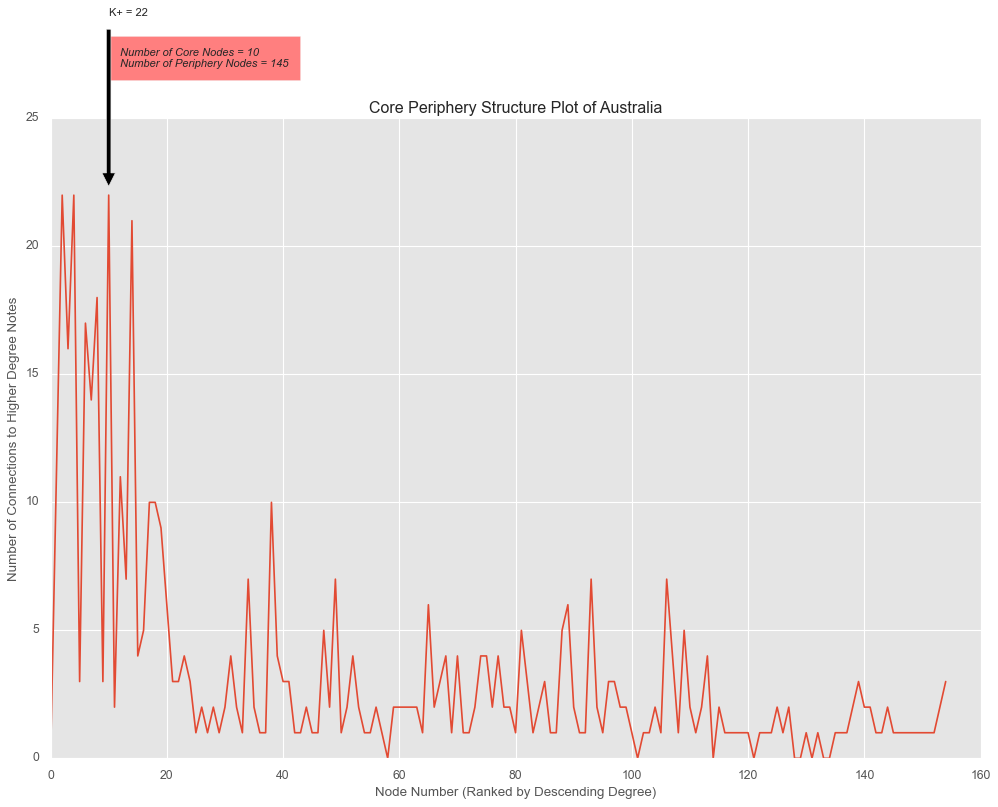

In [45]:

aus=flights_merged[flights_merged['Source Country']=='Australia'].reset_index(drop=True)

G_aus = nx.from_pandas_edgelist(aus,                           
                                source = 'Source', 
                                target = 'Target', 
                                edge_attr = 'Weight',
                                create_using = nx.DiGraph())
degrees= G_aus.degree(weight='Weight')
aus_community_size = aus[['Source','Target']]
aus_community_size['Source Degree']=''
aus_community_size['Target Degree']=''
aus_community_size['Coreness']=''

for i in range(0,len(aus_community_size)):
    aus_community_size.loc[i,'Source Degree'] = degrees[aus_community_size.Source[i]]
    aus_community_size.loc[i,'Target Degree'] = degrees[aus_community_size.Target[i]]
    
    if degrees[aus_community_size.Target[i]] > degrees[aus_community_size.Source[i]]:
        aus_community_size.Coreness[i] = 1
    else:
        aus_community_size.Coreness[i] = 0
aus_community_size=aus_community_size.groupby('Source',as_index=False).agg({'Source':'first','Source Degree':'first','Coreness':'sum'}).reset_index(drop=True)
aus_community_size=aus_community_size.sort_values(by='Source Degree',ascending=False)

coreness = aus_community_size.Coreness.reset_index(drop=True)

fig, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(coreness.tolist())
ax1.set_title('Core Periphery Structure Plot of Australia')
ax1.set_xlabel('Node Number (Ranked by Descending Degree)')
ax1.set_ylabel('Number of Connections to Higher Degree Notes')

max_coreness_pos = np.where(coreness == max(coreness))
max_coreness_pos = np.max(max_coreness_pos)
max_coreness = max(coreness)
x = pd.Series(range(0,len(coreness)))
xmax =  x[max_coreness_pos]

ax1.text(xmax+2, max_coreness+5, 'Number of Core Nodes = {max_coreness_pos}\nNumber of Periphery Nodes = {perip}'.
         format(max_coreness_pos=max_coreness_pos,
                perip=(len(coreness)-max_coreness_pos)), style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
ax1.annotate('K+ = {max_coreness}'.format(max_coreness=max_coreness), xy=(xmax, max_coreness), xytext=(xmax, max_coreness+7),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )



- The Core Periphery Structure method is used to identify densely connected "core" nodes and loosely connected "peripheral" nodes in the network. The degree of each node is compared, and nodes with higher connections are assigned a value of 1, while others are assigned 0. The coreness values are then summed and plotted in descending order of degree.

- For each country, a plot is generated indicating the core-periphery structure. The arrow in the plot represents the cutoff between core and peripheral nodes, and additional information is provided in a red text box. The coreness value (k+) represents the number of connections a node has with higher-ranked nodes.

- The analysis shows that UK and China have larger core community sizes, indicating greater robustness and stability. On the other hand, Australia and USA have smaller core community sizes, suggesting lower robustness to failures.

